# Brief

# Veille

Question de veilles:

Qu'est ce que le clustering ? Est ce un probleme difficile ? pourquoi ?

    - qu'elle est la compléxité d'un probléme de clustering ? 
    - Quelle sont les métrique utilisé pour le clustering ?
    - Ecriver en une phrase votre comprhéension pour chaque métrique découverte
    - séparer les métrique avec "ground truth" et "sans "ground truth".
    - différenc entre NMI et AMI ?


Introducing k-Means

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

   - The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
   - Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the k-means model.

Qu'est ce que le clustering ? Est ce un probleme difficile ? pourquoi ?

Le clustering est une méthode d’apprentissage non supervisé (unsupervised learning). Ainsi, on n’essaie pas d’apprendre une relation de corrélation entre un ensemble de features X d’une observation et une valeur à prédire Y, comme c’est le cas pour l’apprentissage supervisé. L’apprentissage non supervisé va plutôt trouver des patterns dans les données. Notamment, en regroupant les choses qui se ressemblent.

Il existe des types de clustering :

• hiérarchique/ non hiérarchique
  – Le clustering hiérarchique: Un    ensemble de clusters imbriqués organisée en arbre hiérarchique   
  – Le clustering non-hiérarchique (partitionnement): Une division des données en sous-ensembles qui ne se chevauchant pas   


• Exclusif / non exclusif    
 – Dans un clustering non exclusif, un point peut appartenir à plusieurs clusters   
 – Peut représenter des classes multiples, ou  des points  à la frontière    

• Clustering flou (fuzzy)    
  – Dans le clustering flou, un point apparaent à chaque cluster avec un poids compris entre 0 et 1    
  – La somme des poids d’un  point  est 1    
  – Notion de  probabilité    
  
• Partiel / complet   
  – Dans certain cas, nous ne  voulons clusteriser  qu’une  partie des données    
  
• Hétérogène  / homogène    
 – Les clusters peuvent varier en taille, forme, et densité   


L'une des principales difficultés des méthodes de clustering est la définition du nombre de clusters optimal. En augmentant le nombre de classes, l'homogénéité totale des clusters augmente mécaniquement mais complexifie la compréhension d'ensemble.

La qualité d’un clustering dépend de la mesure de similarité (une mesure subjective).

>> Les caractéristiques des données d’entrée sont importantes    
• Type de mesure  de  proximité ou densité : Impacte important sur le clustering
• Type des atributs : Joue sur la fonction de similarité    
• Type de données    
• Nombre de dimensions    
• Bruit / valeurs aberrantes    
• Distribution des données    

Qu’est ce que K-means

K-means est un algorithme non supervisé de clustering non hiérarchique. Il permet de regrouper en K clusters distincts les observations du data set. Ainsi les données similaires se retrouveront  dans un même cluster. Par ailleurs, une observation ne peut se retrouver que dans un cluster à la fois (exclusivité d’appartenance). Une même observation, ne pourra donc, appartenir à deux clusters différents.

Introducing k-Means

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

    The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
    Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the k-means model.

Principe algorithmique

Algorithme K-means

Entrée : 

    K le nombre de cluster à former
    Le Training Set (matrice de données)

DEBUT

Choisir aléatoirement K points (une ligne de la matrice de données). Ces points sont les centres des clusters (nommé centroïd).

                      REPETER

Affecter chaque point (élément de la matrice de donnée) au groupe dont il est le plus proche au son centre

Recalculer le centre de chaque cluster  et modifier le centroide

                     JUSQU‘A     CONVERGENCE

                               OU    (stabilisation de l’inertie totale de la population)

FIN ALGORITHME

Note 1: Lors de la définition de l’algorithme, quand je parle de “point”, c’est un point au sens “donnée/data” qui se trouve dans un espace vectoriel de dimension n. Avec n : le nombre de colonnes de la matrice de données.

Note 2 : La convergence de l’algorithme K-Means peut être l’une des conditions suivantes :

    Un nombre d’itérations fixé à l’avance, dans ce cas, K-means effectuera les itérations et s’arrêtera peu importe la forme de clusters composés.
    Stabilisation des centres de clusters (les centroids ne bougent plus lors des itérations).

L’affectation d’un point \lambda  à un cluster se fait en fonction de la distance de ce point par rapport aux différents K centroides. Par ailleurs, ce point \lambda se fera affecté à un cluster i s’il est plus proche de son centroid (distance minimale). Finalement, la distance entre deux points dans le cas de K-Means se calcule par les méthodes évoquées dans le paragraphe “notion de similarité”.


Qu'elle est la compléxité d'un probléme de clustering ? 
Complexité: O (Kndl) où l est le nombre d'itérations.

L’étape de recherche des médoïdes a pour conséquence une complexité O(N2), alors que la complexité de K-means est plutôt O(N) (ou O(N4/3) si on tient compte du fait que le nombre de centres dépend de N).

Pour K-means, l’initialisation a un impact important sur la qualité de la solution (du minimum local obtenu) et sur la rapidité de la convergence (le nombre d’itérations nécessaire). Il est conseillé d’employer une initialisation suivant le même principe que K-means++, c’est à dire la sélection séquentielle des centres (médoïdes ici) en maximisant l’éloignement de chaque nouveau centre des centres déjà choisis.

- Quelle sont les métrique utilisé pour le clustering ?

https://scikit-learn.org/stable/modules/classes.html?highlight=metric#module-sklearn.metrics.cluster
    


- Ecriver en une phrase votre comprhéension pour chaque métrique découverte
- séparer les métrique avec "ground truth" et "sans "ground truth".
- différenc entre NMI et AMI ?

# Code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
#loading the digits
from sklearn.datasets import load_digits
digits = load_digits()
print ("The digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image :" ,digits.data.shape)


The digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image : (1797, 64)


In [46]:
#inding the KMeans clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

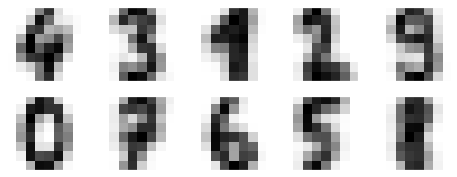

In [47]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:


In [48]:
#matching each learned cluster label with the true labels found in them :

from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [50]:
#Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:
from sklearn.metrics import accuracy_score

print("Accuracy_KMeans score :", accuracy_score(digits.target, labels))

Accuracy_KMeans score : 0.7952142459654981


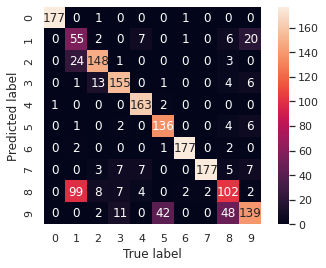

In [54]:
#With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits! Let's check
#the confusion matrix for this:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

As we might expect from the cluster centers, the main point of confusion is between the eights and ones. But this shows that using k-means, we can essentially build a digit classifier without reference to any known labels!
Almost 80% of  KMeans classification accuracy score.

Just for fun, let's try to push this even farther. We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in In-Depth: Manifold Learning) to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see how it does:

In [43]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
 
# Compute the accuracy
print("Accuracy_Tsne score :", accuracy_score(digits.target, labels))

Accuracy_Tsne score : 0.9371174179187535


That's nearly 94% Tsne classification accuracy score without using the labels. This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

# Datas vizualization with tsne treatment and with kmeans treatment

In [9]:
#PCA with tsne treated datas
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_tsne=pca.fit(digits_proj)

print(pca_tsne.explained_variance_ratio_)
print (pca_tsne.singular_values_)

[0.59324676 0.40675327]
[1465.1588 1213.2004]


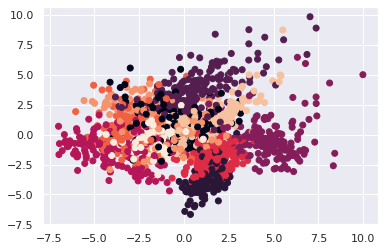

In [34]:
# Matplolib Datas visualisation on tsne treated datas

clusters_tsne = kmeans.fit_predict(digits_proj)
plt.scatter(pca_data[:,0], pca_data[:,1], c= clusters_tsne)

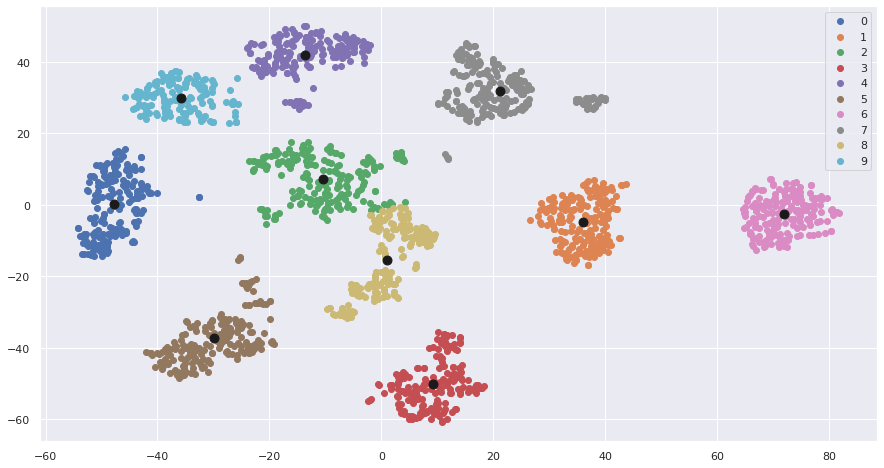

In [40]:
# Plotly Datas visualisation on tsne treated datas

model3 = kmeans.fit_predict(digits_proj)

centroids = kmeans.cluster_centers_
unique_labels = np.unique (model3)

# plot 

fig = plt.figure (1, figsize=(15,8))
for i in unique_labels :
    plt.scatter(digits_proj[model3  == i , 0 ], digits_proj[model3  == i , 1], label = i)

plt.scatter(centroids[:,0], centroids [:,1], s=80, color = 'k')
plt.legend()
plt.show()

In [35]:
#PCA with kmeans treated data
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scale(digits.data))

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.12033916 0.09561054]
[114.85302699 102.37451345]


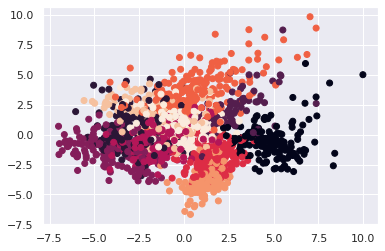

In [26]:
# Matplolib Datas visualisation with kmeans treated datas

plt.scatter(pca_data[:,0], pca_data[:,1], c= clusters)


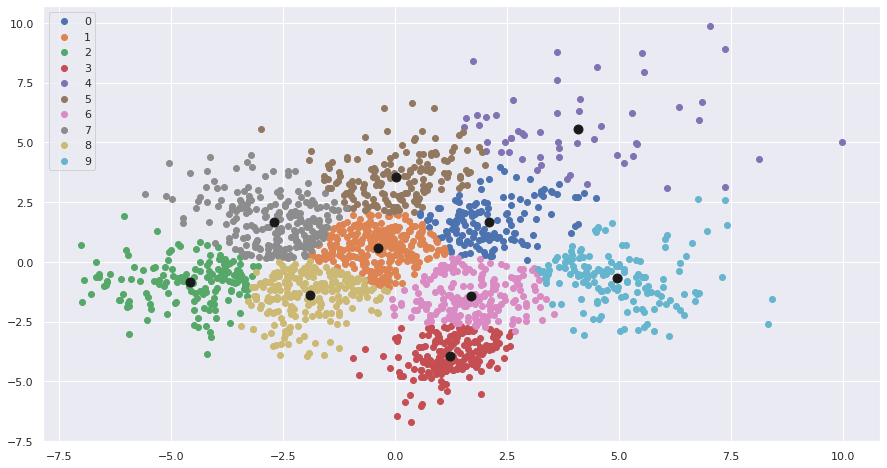

In [27]:
# Plotly Datas visualisation with kmeans treated datas

model2 = kmeans.fit_predict(pca_data)

centroids = kmeans.cluster_centers_
unique_labels = np.unique (model2)

# plot 

fig = plt.figure (1, figsize=(15,8))
for i in unique_labels :
    plt.scatter(pca_data[model2  == i , 0 ], pca_data [model2  == i , 1], label = i)

plt.scatter(centroids[:,0], centroids [:,1], s=80, color = 'k')
plt.legend()
plt.show()

The results are clearly better and more clear with tse algotithm

# Kmeans vizualisation datas with PCA & Pipeline

In [28]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print( f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [29]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(kmeans, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    
    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]

    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]
    # The silhouette score requires the full dataset
    results += [ metrics.silhouette_score(data, estimator[-1].labels_, metric="euclidean", sample_size=300,) ]
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)

bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.319s	69485	0.613	0.660	0.636	0.482	0.632	0.136
random   	0.162s	69952	0.545	0.616	0.578	0.415	0.574	0.125
PCA-based	0.065s	72686	0.636	0.658	0.647	0.521	0.643	0.150
__________________________________________________________________________________


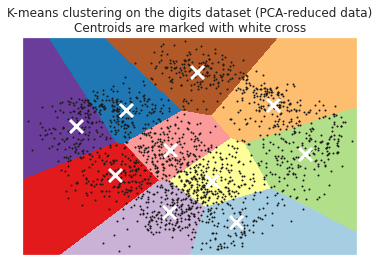

In [31]:
#Visualize the results on PCA-reduced data
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()